<a href="https://colab.research.google.com/github/Priyansh012/CECS550-Facial-Expression-Recognition/blob/main/CNN_BASED_Facial_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T204833Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D243e64b93c1ce539cdeab00a46ba4693589bd9068c3087da20071a70b394283901a6218530b8cd14052c42ef057caa2c6b97f56c4cb271d3f76d51aadfc33753a2e715ea7ce8d15d0a3962674f7c0fa856f3f4c903641f820856a60577007d9ca18cda4d3debfa05aa2a52f2dfc8af03da1d0af44c769a510c7e7cc36d35cdd606b27fe06d634375c2b808a807ffa17890f44272e735d71b03f7e416e44e7a90b1de7ed8d051115f5b4e4ac030794783d9c6ceabfa3faf956c8a46a3f06c4c3f2bc56d8e46c7440aafbf5816ad55f0cd31fec34e35fa86642e2657c7fb0f29e2d0c356ff74e220104c057581280ec2a600c2682aaae998638192021f4e22bebd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_src_map in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_src_map.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    dest_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as file_res, NamedTemporaryFile() as temp_file:
            total_length = file_res.headers['content-length']
            print(f'Downloading {directory} - Compressed size: {total_length} bytes.')
            dl = 0
            data = file_res.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                temp_file.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] Download progress: {dl} bytes")
                sys.stdout.flush()
                data = file_res.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(temp_file) as zip_file:
                zip_file.extractall(dest_path)
            else:
              with tarfile.open(temp_file.name) as t_file:
                t_file.extractall(dest_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) data from {download_url} to path {dest_path}')
        continue
    except OSError as e:
        print(f'Failed to load data from {download_url} to path {dest_path}')
        continue

print('Data source import complete.')


[==================================================] Download progress: 63252113 bytes
Downloaded and uncompressed: fer2013
Data source import complete.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_p = "../input/fer2013/train"  # Directory containing the training data
test_data_p = "../input/fer2013/test"    # Directory containing the validation data



train_data_g = ImageDataGenerator(
    width_shift_range = 0.2,        # Randomly shift the width of images by up to 20%
    height_shift_range = 0.2,       # Randomly shift the height of images by up to 20%
    rotation_range = 30,            # Rotate images by up to 30 degrees
    shear_range = 0.2,              # Shear transformation with max intensity of 0.2
    zoom_range = 0.2,               # Zoom images by up to 20%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_data_g = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)


In [ ]:
train_gen = train_data_g.flow_from_directory(
    directory = train_data_p,      # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_gen = validation_data_g.flow_from_directory(
    directory = test_data_p,       # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Define the model architecture
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# Fourth Convolutional Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fifth Convolutional Layer
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# Sixth Convolutional Layer
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Seventh Convolutional Layer (Added)
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Eighth Convolutional Layer (Added)
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7, activation='softmax'))


model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=50,
    validation_data=validation_gen,
    validation_steps=len(validation_gen),
    callbacks=[checkpoint_callback]
)


# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])


Epoch 1/50
359/359 [==============================] - ETA: 0s - loss: 2.2773 - accuracy: 0.1939
Epoch 1: val_accuracy improved from -inf to 0.20810, saving model to model_weights.h5
359/359 [==============================] - 38s 73ms/step - loss: 2.2773 - accuracy: 0.1939 - val_loss: 1.8754 - val_accuracy: 0.2081
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 1.9516 - accuracy: 0.2301
Epoch 2: val_accuracy improved from 0.20810 to 0.24511, saving model to model_weights.h5
359/359 [==============================] - 24s 68ms/step - loss: 1.9516 - accuracy: 0.2301 - val_loss: 1.7865 - val_accuracy: 0.2451
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 1.8747 - accuracy: 0.2474
Epoch 3: val_accuracy improved from 0.24511 to 0.28492, saving model to model_weights.h5
359/359 [==============================] - 24s 67ms/step - loss: 1.8747 - accuracy: 0.2474 - val_loss: 1.7671 - val_accuracy: 0.2849
Epoch 4/50
359/359 [=============================

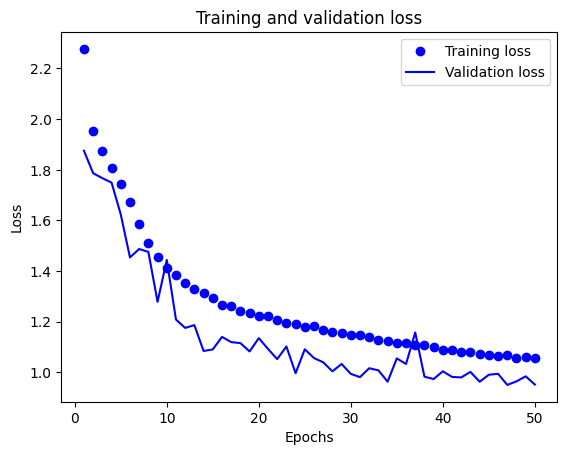

In [ ]:
# Plot the train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

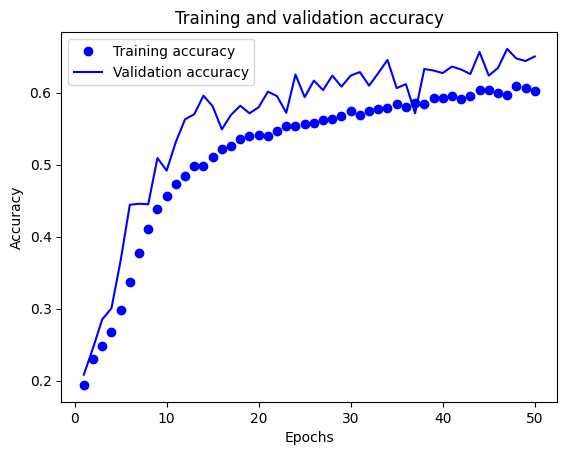

In [ ]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 1s 21ms/step


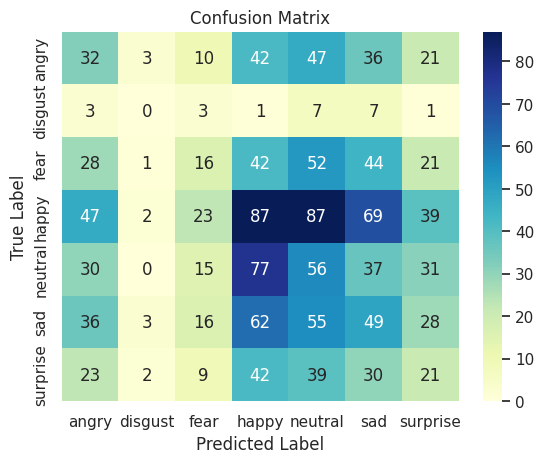

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# Get the true labels and predicted labels for the validation set
validation_labels = validation_gen.classes
validation_pred_probs = model.predict(validation_gen)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_gen.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()